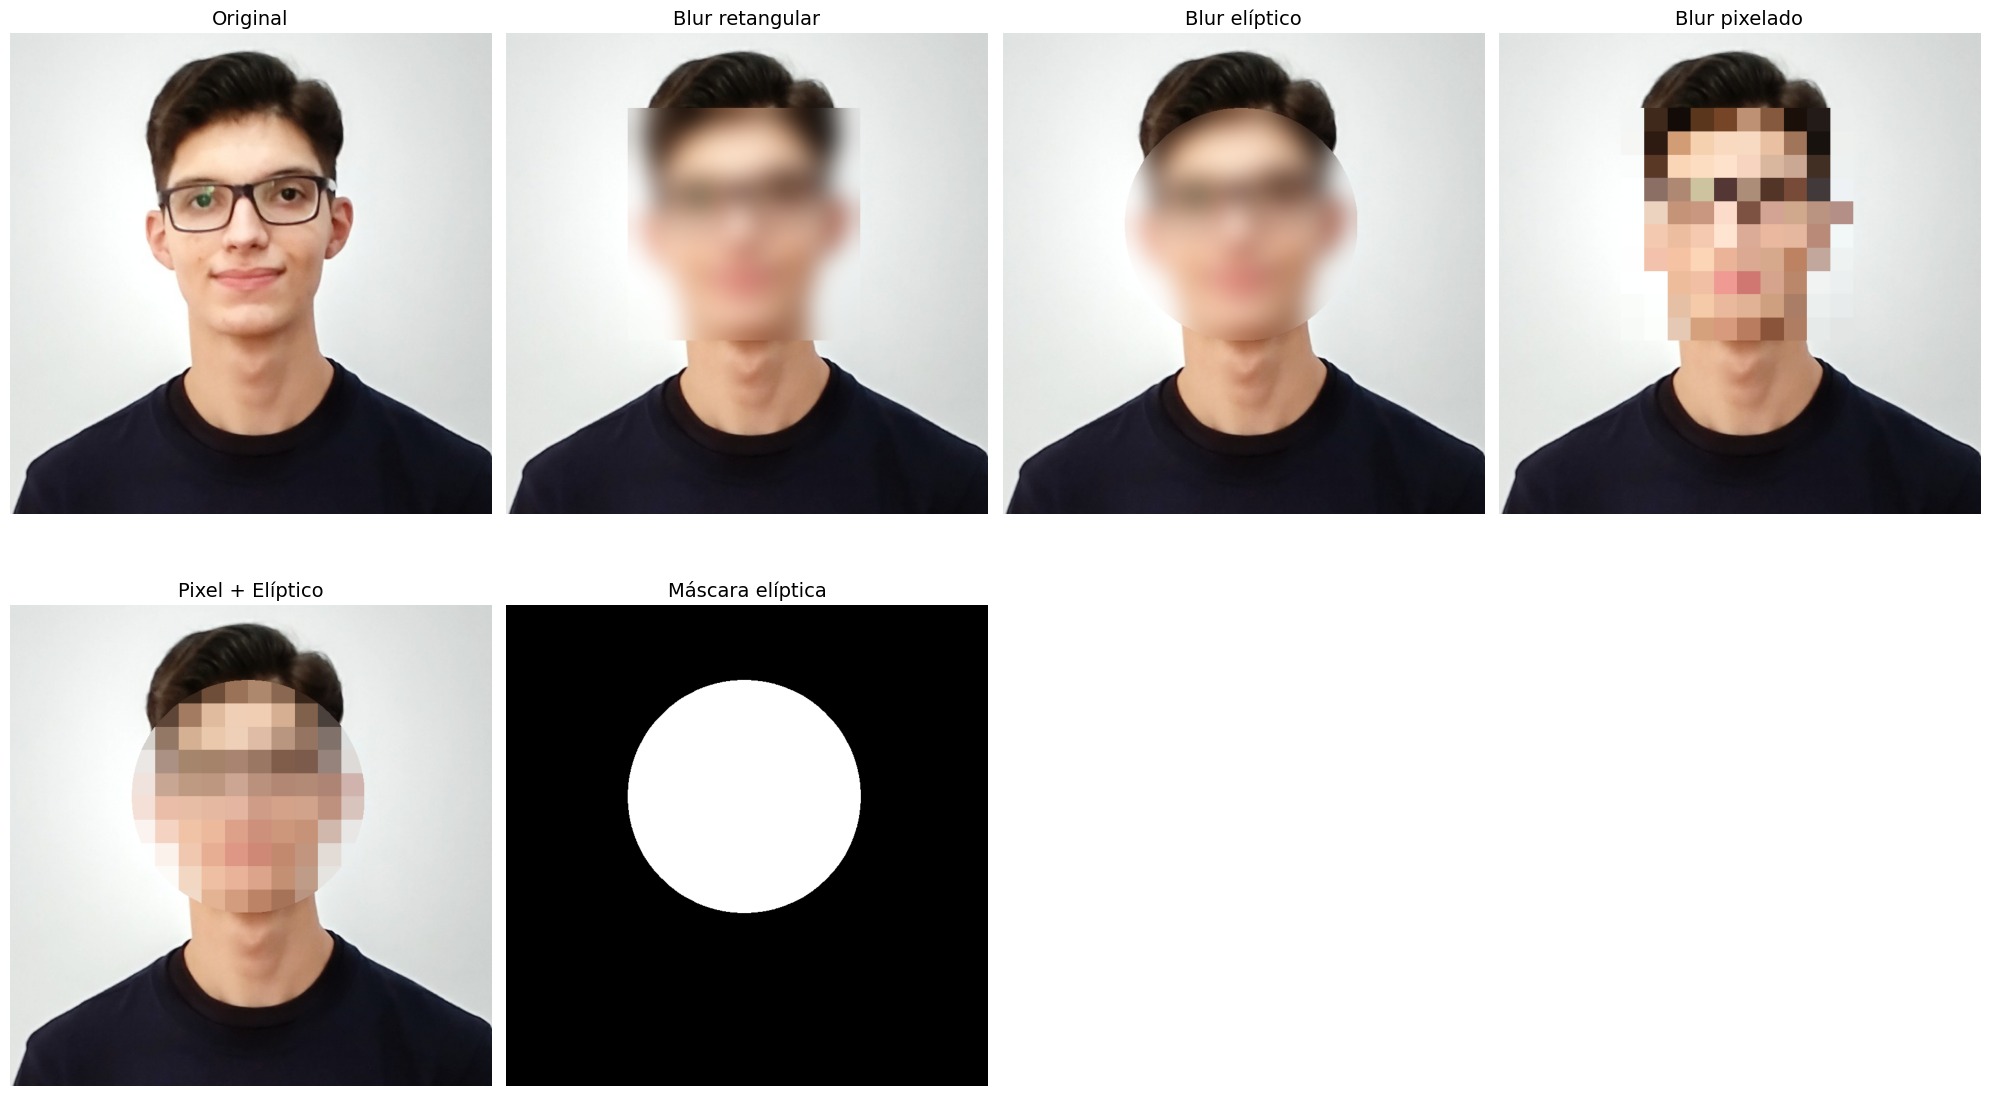

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
%matplotlib inline


img1 = cv2.imread('foto_perfil.jpg', cv2.IMREAD_COLOR)


def blur(face, factor=3):
    h, w = face.shape[:2]
    w_k = max(1, int(w/factor) | 1)
    h_k = max(1, int(h/factor) | 1)
    return cv2.GaussianBlur(face, (w_k, h_k), 0)

def pixelate(roi, pixels=16):
    if roi.size == 0: return roi
    h, w = roi.shape[:2]
    roi_small = cv2.resize(roi, (pixels, pixels))
    return cv2.resize(roi_small, (w, h), interpolation=cv2.INTER_NEAREST)

def apply_blurs(img):
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    results = {
        'original': img.copy(),
        'rect': img.copy(),
        'ellipse': img.copy(),
        'pixel': img.copy(),
        'ellipse_pixel': img.copy(),
        'mask': np.zeros_like(img)
    }

    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]


        results['rect'][y:y+h, x:x+w] = blur(face_roi, factor=3)


        results['pixel'][y:y+h, x:x+w] = pixelate(face_roi, pixels=10)


        mask = np.zeros_like(img)
        center = (int(x + w//2), int(y + h//2))
        axes = (int(w//2), int(h//2))

        cv2.ellipse(
            mask,
            center,
            axes,
            0, 0, 360,
            (255, 255, 255),
            -1
        )


        face_mask = mask[y:y+h, x:x+w]
        blurred_face = blur(face_roi, factor=3)
        results['ellipse'][y:y+h, x:x+w] = np.where(
            face_mask == 255,
            blurred_face,
            results['ellipse'][y:y+h, x:x+w]
        )


        pixel_face = pixelate(blurred_face, pixels=10)
        results['ellipse_pixel'][y:y+h, x:x+w] = np.where(
            face_mask == 255,
            pixel_face,
            results['ellipse_pixel'][y:y+h, x:x+w]
        )


        results['mask'] = cv2.bitwise_or(results['mask'], mask)

    return results

blur_results = apply_blurs(img1)

titles = [
    ('Original', blur_results['original']),
    ('Blur retangular', blur_results['rect']),
    ('Blur elíptico', blur_results['ellipse']),
    ('Blur pixelado', blur_results['pixel']),
    ('Pixel + Elíptico', blur_results['ellipse_pixel']),
    ('Máscara elíptica', blur_results['mask'])
]

fig = plt.figure(figsize=(20, 12))
for idx, (title, img) in enumerate(titles, 1):
    plt.subplot(2, 4, idx)
    plt.imshow(img[:,:,::-1])
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

### OBS: Houve dificuldade em aplicar o modelo DNN no Colab:

### 1 - Podemos deixar de usar os dados do arquivo .xml?
#### Sim, podemos deixar de usar o arquivo .xml se trocarmos o método de detecção, como por exemplo utilizando um modelo DNN, que carrega pesos e configurações de outro formato .
### 2 - Qual a importância desses dados?
#### O arquivo .xml do Haar Cascade contém os classificadores treinados com padrões faciais. Ele é essencial para o funcionamento do método Haar, pois define os padrões usados para detectar rostos de forma rápida.
### 3 - É possível perceber qual implementação realiza a predição mais rapidamente?
#### O Haar Cascade usa classificadores simples baseados em features manuais e é rápido, mas menos preciso e sensível a variações. Já o DNN utiliza redes neurais profundas, oferecendo maior precisão e robustez, porém com maior custo computacional. Assim, Haar é ideal para aplicações leves e em tempo real, enquanto DNN é mais indicado quando a qualidade da detecção é altamente relevante.
